# Classification Using Parameterized Quantum Circuit 

This Jupyter notebook demonstrate classification algorithm via connecting qiskit machine learning module and the parameteterized quantum circuit (PQC) to replicate the work by Thomas Hubregtsen [ArXiv](https://arxiv.org/abs/2003.09887). This notebook generate the simple example dataset and test qiksit machine learning algorithm for four qubit case. Qiskit mentorship program [Github page](https://github.com/qiskit-community/qiskit-advocate-mentorship-program/issues/11).<br/>

Mentee: Saesun Kim <br/>
Mentor: Travis L Scholten 

![PQC machine-learning](PQC1.jpg)

There are three part of the classification algorithm: embeding, PQC, and optimization. The coordinate of the classical data is embeded in four qubit circuit using Rx rotation followed by pi/4 rotationg with Ry Rz gate. After that, the circuit is sent to PQC circuits, then measurement is marked with 0 and 1 by paper's definition. We calculate the loss according to the classical data, and the loss is sent to optimizer to find the parameters for the PQC. We iterate the process to minize the loss.

## Import Module

In [10]:
import qiskit
from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

qiskit.__qiskit_version__

{'qiskit-terra': '0.17.4', 'qiskit-aer': '0.8.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-aqua': None, 'qiskit': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [11]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from pandas.core.common import flatten

import torch
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 

import torch.optim as optim

torch.cuda.is_available()

True

## Prepare the dataset
We generate simple two seperable dataset.

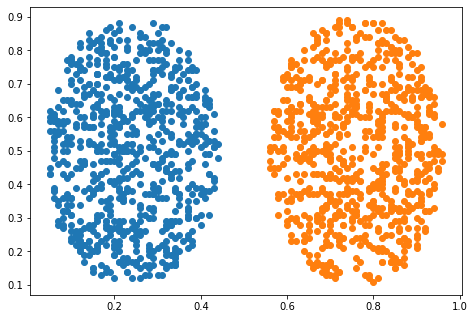

In [12]:
# import the example dataset from the folder
# data = array([x1,y1],[x2,y2],[x3,y3],.....,[x1500,y1500])
# label = array([0,0,0,....,1,1,1])

data0Path = r'data.txt' 
data0Label = r'datalabel.txt'
dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

In [13]:
# Change the data structure for shuffling
# We are taking 100 data to train the model

np.random.seed(2)
data1 = list(zip(dataCoords, dataLabels))
data_ixs = np.random.choice(len(data1), size=100)

# Transform the data to work with the pytorch optimizer.
# data coordinate X is [x1,y1,x1,y1] to embed in four-qubit circuit.

X= [np.array(list(flatten([data1[j][0],data1[j][0]]))) for j in data_ixs]
y01 = [data1[j][1] for j in data_ixs]

X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y01)).long()

In [28]:
n=4;    
feature_map = QuantumCircuit(n, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
for i in range(n):
    feature_map.ry(pi/4,i)
for i in range(n):
    feature_map.rz(pi/4,i)    

In [29]:
param_y=[];
for i in range(8):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(n, name='PQC')
for i in range(n):
    ansatz.ry(param_y[i],i)
for i in range(n):
    ansatz.rz(param_y[i+4],i)

In [30]:
def binary(x):
    return ('0'*(4-len('{:b}'.format(x) ))+'{:b}'.format(x))
def firsttwo(x):
    return x[:2]
parity = lambda x: firsttwo(binary(x)).count('1') % 2

In [18]:
[parity(i) for i in range(16)]

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

## Optimizer 
In this notebook, we showed two optimization examples: LBFGS and Adam optimizer. CircuitQNN and TorchConnector are used to optimizer the loss.

In [32]:
qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))

In [33]:
# Model for LBFGS
# Combining the circuit together with CircuitQNN
np.random.seed(3)
qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=2, quantum_instance=qi)
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

# Model for Adam
np.random.seed(3)
qnn3 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=2, quantum_instance=qi)
initial_weights = 0.1*(2*np.random.rand(qnn3.num_weights) - 1)
model3 = TorchConnector(qnn3, initial_weights)

In [34]:
# define optimizer and loss function
optimizer = LBFGS(model2.parameters(),lr=0.01)
f_loss = CrossEntropyLoss()

In [22]:
# start training
model2.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)

70.28067779541016
70.20629119873047
70.09725952148438
69.59834289550781
67.42364501953125
67.24382019042969


KeyboardInterrupt: 

Accuracy: 0.46


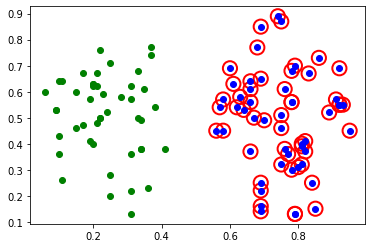

In [35]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

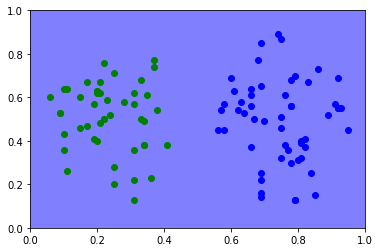

In [36]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
        
X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

In [37]:
# Converged paramter for the PQC
for p in model2.parameters():
    print(p.data)

tensor([ 0.0102,  0.0416, -0.0418,  0.0022,  0.0786,  0.0793, -0.0749, -0.0586])


## 2) Adam optimizer

In [38]:
optimizer = optim.Adam(model3.parameters(),lr=0.05)
f_loss = MSELoss(reduction='mean')

In [39]:
model3.train()   
epochs = 10     # set number of epochs

for epoch in range(epochs):
    optimizer.zero_grad()                                  
    loss = 0.0                                               
    for x, y_target in zip(X, y01):                        
        output = model3(Tensor(x)).reshape(1, 2)           
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                                        
    print(loss.item())                                   

    optimizer.step()

28.71188735961914
27.893327713012695


KeyboardInterrupt: 

Accuracy: 0.46


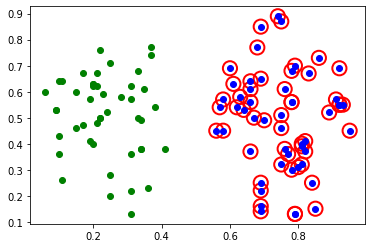

In [40]:
y_predict = []
for x in X:
    output = model3(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

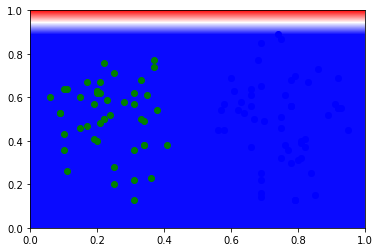

In [44]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
        
X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

for j in range(len(X1)):
    for k in range(len(X1)):
        Z1[j, k] = np.argmax(model3(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

In [41]:
for p in model3.parameters():
    print(p.data)

tensor([ 0.0102,  0.0416,  0.0578,  0.1018,  0.0786,  0.0793, -0.0749, -0.0586])
